# HOW DO RIDERS RIDE ON THE WEEKEND?

### In this notebook... I will use the MTA Subway Hourly Ridership data for the month of January to gain insights into the different types of weekend ridership behaviors across the system.

### Why carry out such an analysis?

An analysis of the weekend ridership behavior of the MTA Subway system can provide valuable insights into the flow of population in the subway system, which the MTA can leverage in a variety of ways for a smoother and more efficient operation. 

Subway Scheduling: By knowing how the subway is being ridden on the weekends, the MTA can accorindgly schedule more or less trains on lines as such, thus optimizing resource allocation. Furthermore, the MTA can consider adding express trains on lines with considerable commuter traffic on the weekends, facilitating the commutes of the millions of daily riders. A smart scheduling strategy gurantees a most efficient service for the customer, and a most profitable operation for the MTA.

Maintenance: The MTA could also use this information for scheduling maintenance intelligently. While maintenance is necessary for the continued success of the subway station, it is also important that maintenance be scheduled in a way that affects the least amount of customers. The naive solution is to schedule maintenance on weekends and/or late nights. However, it may be worthwhile to consider the ridership behavior of certain stations on weekends to make a more well informed decision, scheduling around the riders commuting behavior so as to cause minimal disruption to the system.

With these considerations in mind, let me proceed with an analysis of the Jnauary 2025 MTA Subway Hourly Ridership dataset (obtained from https://data.ny.gov/fr/Transportation/MTA-Subway-Hourly-Ridership-Beginning-2025/5wq4-mkjj/about_data).


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.patches as mpatches

import datetime

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA

from sklearn.preprocessing import normalize

from scipy.fft import fft, ifft


/Users/amritnijjar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/amritnijjar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Understanding the dataset

This dataset tabulates the hourly ridership for every subway station in the MTA subway system. For subway travel, the MTA only records payment as a passenger enters a station, but not as they exit. Because of this, it is not directly clear from the ridership data alone which subway line a passenger might have travelled via.

In [2]:
# Read in data-file
df = pd.read_csv('MTA_Subway_Hourly_Ridership__Beginning_2025.csv', low_memory=False)
print(df.head())
print(f'There are {df.shape[0]} entries in this dataset.\n')
print(f'The columns in this data set are: \n{df.columns.to_list()}.')
df.describe()

        transit_timestamp transit_mode station_complex_id station_complex  \
0  01/09/2025 06:00:00 PM       subway                455       69 St (7)   
1  01/07/2025 08:00:00 PM       subway                385      176 St (4)   
2  01/03/2025 06:00:00 PM       subway                405       23 St (6)   
3  01/01/2025 02:00:00 AM       subway                388      167 St (4)   
4  01/04/2025 01:00:00 PM       subway                282       21 St (G)   

     borough payment_method fare_class_category  ridership  transfers  \
0     Queens           omny     OMNY - Students         11          0   
1      Bronx           omny     OMNY - Students          8          0   
2  Manhattan           omny        OMNY - Other          3          0   
3      Bronx           omny     OMNY - Students          5          0   
4     Queens           omny        OMNY - Other          1          0   

    latitude  longitude                 Georeference  
0  40.746326  -73.89640   POINT (-73.8964 4

,ridership,transfers,latitude,longitude
count,2.316609e+06,2.316609e+06,2.316609e+06,2.316609e+06
mean,4.170317e+01,1.842805e+00,4.073370e+01,-7.393651e+01
std,1.802530e+02,1.205854e+01,7.755553e-02,5.464120e-02
min,1.000000e+00,0.000000e+00,4.057613e+01,-7.407484e+01
25%,3.000000e+00,0.000000e+00,4.067882e+01,-7.398133e+01
50%,9.000000e+00,0.000000e+00,4.072591e+01,-7.394764e+01
75%,2.600000e+01,1.000000e+00,4.079392e+01,-7.390087e+01
max,1.594000e+04,1.405000e+03,4.090313e+01,-7.375540e+01


In [3]:
# This dataset includes data for the subway, staten island railway, and roosevelt island tram.
df = df[df['transit_mode'] == 'subway']

In [4]:
# DataFrame for station iformation
station_info_df = df[["station_complex", "borough", "latitude", "longitude", "Georeference"]].drop_duplicates()

In [5]:
# remove columns which are not necessary in analysis df
df = df.drop(columns=['latitude', 'longitude', 'Georeference', 'station_complex_id', 'transit_mode', 'fare_class_category'])


In [6]:
# Data is timestamped but out of order...
# convert to datetime and sort by datetime
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df = df.sort_values(by = 'transit_timestamp')
df = df.reset_index(drop = True)

/var/folders/x5/mt3y0q2n65zcpd0hz503pkx00000gn/T/ipykernel_76545/20143674.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


In [7]:
# Entries for each station at each timestamp are bifurcated by payment method (omny or metrocard).
# Aggregate ridership by timestamp/station
print(df.shape)
df_aggd = df.groupby(['transit_timestamp', 'station_complex'], as_index = False).agg({'ridership': 'sum'})
print(df_aggd.shape)
df_aggd.head()

(2298327, 6)
(298241, 3)


,transit_timestamp,station_complex,ridership
0,2025-01-01,1 Av (L),585
1,2025-01-01,103 St (1),141
2,2025-01-01,103 St (6),53
3,2025-01-01,"103 St (C,B)",54
4,2025-01-01,103 St-Corona Plaza (7),123


## Subway Station Ridership Pattern Analysis

It is clear that there is a wide difference in any stations weekday and weekend daily ridership pattern. For example, the plots below show the difference between ridership for the 1 Av station complex, with service to the L, on a weekday and weekend, normalized to show the fraction of maximum riders at a given hour.

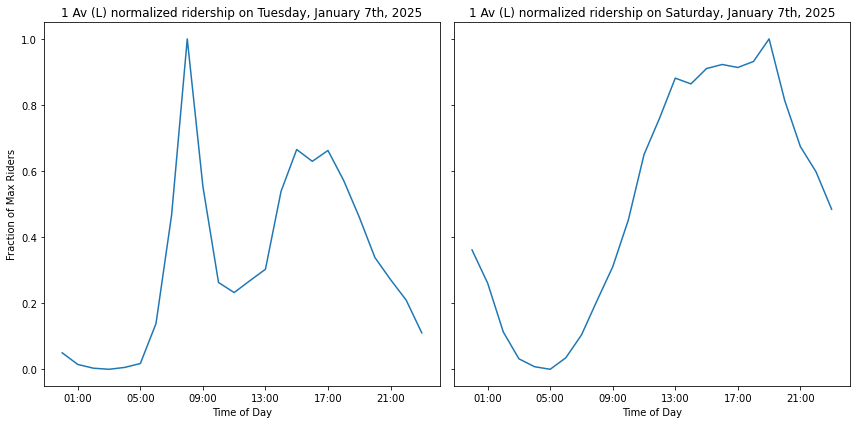

In [8]:
def station_weekday_vs_weekend_plots(station_complex, df):
    station_ridership = df[df["station_complex"] == station_complex][["transit_timestamp", "ridership"]]
    station_ridership["transit_day"] = station_ridership["transit_timestamp"].dt.day
    station_ridership["transit_hour"] = station_ridership["transit_timestamp"].dt.hour
    station_ridership = station_ridership[["transit_day", "transit_hour", "transit_timestamp", "ridership"]]

    station_ridership_weekday = station_ridership[station_ridership["transit_day"] == 7][["ridership"]].to_numpy()
    station_ridership_weekday = (station_ridership_weekday - station_ridership_weekday.min()) / (station_ridership_weekday.max() - station_ridership_weekday.min())
    
    station_ridership_weekend = station_ridership[station_ridership["transit_day"] == 11][["ridership"]].to_numpy()
    station_ridership_weekend = (station_ridership_weekend - station_ridership_weekend.min()) / (station_ridership_weekend.max() - station_ridership_weekend.min())

    fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)


    times = pd.DataFrame([pd.Timestamp(year = 2025, month = 1, day = 1, hour = i) for i in range(24)])

    axs[0].plot(np.array(times), station_ridership_weekday)
    axs[1].plot(np.array(times), station_ridership_weekend)

    axs[0].xaxis.set_major_locator(dates.HourLocator(interval=4))
    axs[0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

    axs[0].set_title(f"{station_complex} normalized ridership on Tuesday, January 7th, 2025")
    axs[0].set_ylabel("Fraction of Max Riders")
    axs[0].set_xlabel("Time of Day")

    axs[1].xaxis.set_major_locator(dates.HourLocator(interval=4))
    axs[1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

    axs[1].set_title(f"{station_complex} normalized ridership on Saturday, January 7th, 2025")
    #axs[1].set_ylabel("# Riders")
    axs[1].set_xlabel("Time of Day")
    fig.tight_layout()
    
station_weekday_vs_weekend_plots("1 Av (L)", df_aggd)

The above shows the two most obvious classes of daily ridership plot, Weekend vs. Weekday. A natural question that arises is, what other sorts of daily ridership plot could exist? 

For example, within weekday plots, a Friday plot may exhibit an enhanced second peak, without so sharp a drop, due to many riders' weekends starting with a night out.

Another example is shown below, weekday-weekend ridership plots for the Kingsbridge Rd station complex, with service to the 4. This weekend plot is drastically different from the one above, it in fact closer resembles a weekday plot, with the two distinct peaks centering around clock-in/clock-out times.

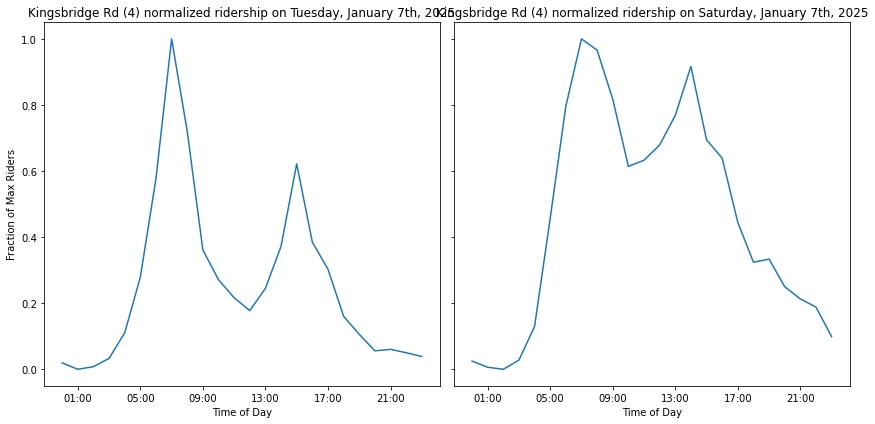

In [9]:
station_weekday_vs_weekend_plots("Kingsbridge Rd (4)", df_aggd)

An interesting analysis would then be, to categorize the *types of daily ridership* for the different stations across different days. To perform this analysis the dataset needs to be restrucered, so that each entry corresponds to one day of ridership, with 24 columns for the ridership of each hour of the day.

In [10]:
df_stripped = df_aggd[["transit_timestamp", "station_complex", "ridership"]]
df_stripped["transit_hour"] = df_stripped["transit_timestamp"].dt.hour
df_stripped["transit_day"] = df_stripped["transit_timestamp"].dt.day


def make_day_station_col(day, station):
    result = "day_" + str(day)+"_station_" + station
    result = result.replace(" ", "_")
    result = result.replace("(", "")
    result = result.replace(")", "")
    result = result.replace(",", "")
    return result

df_stripped["day_at_station"] = df_stripped.apply(lambda x: make_day_station_col(x['transit_day'], x['station_complex']), axis=1)

day_at_station_key = df_stripped[["day_at_station", "transit_day", "station_complex"]]
day_at_station_key.drop_duplicates(inplace=True)

df_stripped = df_stripped[["day_at_station", "transit_hour", "ridership"]]
df_stripped.head()

,day_at_station,transit_hour,ridership
0,day_1_station_1_Av_L,0,585
1,day_1_station_103_St_1,0,141
2,day_1_station_103_St_6,0,53
3,day_1_station_103_St_CB,0,54
4,day_1_station_103_St-Corona_Plaza_7,0,123


In [11]:
# Pivot above table so day_at_station is index, and there is a column per hour, showing ridership values
daily_station_ridership_by_hour = df_stripped.pivot(index = "day_at_station", columns = "transit_hour", values = "ridership").reset_index().rename_axis(None, axis=1)

# Some missing values (original dataset does not enter data whenever/wherever there may be zero ridership)
daily_station_ridership_by_hour.fillna(0., inplace = True)

# Rename hour columns
daily_station_ridership_by_hour.rename(columns = {i : "hour_" + str(i) for i in range(24)}, inplace=True)
hour_columns = ["hour_" + str(i) for i in range(24)]

# Add column for total ridership for given day/station
daily_station_ridership_by_hour["tot_ridership"] = daily_station_ridership_by_hour[hour_columns].sum(axis=1)

# And norm'd
daily_station_ridership_by_hour["tot_ridership_norm"] = (daily_station_ridership_by_hour["tot_ridership"] - daily_station_ridership_by_hour["tot_ridership"].min())/(daily_station_ridership_by_hour["tot_ridership"].max() - daily_station_ridership_by_hour["tot_ridership"].min())

# Add column 1 for weekdays 0 for weekends
modulo_seven_weekdays = [0, 1, 2, 3, 6]
daily_station_ridership_by_hour["is_weekday"] = daily_station_ridership_by_hour["day_at_station"].apply(lambda x: int(int(x.split("_")[1])%7 in modulo_seven_weekdays))

daily_station_ridership_by_hour = daily_station_ridership_by_hour[["day_at_station", "is_weekday", "tot_ridership", "tot_ridership_norm"] + hour_columns]

# MIN-MAX normalize ridership data across all hours
mins = daily_station_ridership_by_hour[hour_columns].min(axis=1)
maxs = daily_station_ridership_by_hour[hour_columns].max(axis=1)
daily_station_ridership_by_hour[hour_columns] = daily_station_ridership_by_hour[hour_columns].apply(lambda x: (x - mins[x.name])/(maxs[x.name] - mins[x.name]), axis = 1)
daily_station_ridership_by_hour = daily_station_ridership_by_hour.merge(day_at_station_key, how="inner", on="day_at_station")

daily_station_ridership_by_hour = daily_station_ridership_by_hour[["transit_day", "station_complex", "is_weekday", "tot_ridership", "tot_ridership_norm"] + hour_columns]


In [12]:
daily_station_ridership_by_hour.head()

,transit_day,station_complex,is_weekday,tot_ridership,tot_ridership_norm,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,10,103 St-Corona Plaza (7),1,19925.0,0.136286,0.004132,0.000000,0.001271,0.015575,0.109663,0.410362,0.682454,1.000000,0.742212,0.408773,0.314050,0.220915,0.203433,0.249523,0.346790,0.297203,0.267959,0.241577,0.183408,0.153528,0.096631,0.079466,0.064209,0.041958
1,10,103 St (1),1,8880.0,0.060735,0.037797,0.007559,0.000000,0.000000,0.007559,0.042117,0.167387,0.619870,1.000000,0.632829,0.453564,0.511879,0.451404,0.479482,0.553996,0.667387,0.699784,0.785097,0.765659,0.474082,0.301296,0.258099,0.199784,0.136069
2,10,103 St (6),1,9334.0,0.063840,0.017586,0.001599,0.000799,0.000000,0.027178,0.074341,0.205436,0.550759,0.605915,0.353317,0.278177,0.300560,0.296563,0.353317,0.552358,1.000000,0.784972,0.735412,0.392486,0.294165,0.183853,0.109512,0.085532,0.065548
3,10,"103 St (C,B)",1,3072.0,0.021006,0.000000,0.000000,0.000000,0.000000,0.000000,0.080729,0.257812,0.716146,1.000000,0.565104,0.388021,0.375000,0.375000,0.398438,0.549479,0.567708,0.611979,0.640625,0.591146,0.341146,0.260417,0.161458,0.067708,0.052083
4,10,104 St (A),1,1249.0,0.008537,0.013393,0.008929,0.000000,0.044643,0.089286,0.410714,0.794643,1.000000,0.705357,0.263393,0.258929,0.165179,0.187500,0.200893,0.361607,0.267857,0.250000,0.138393,0.107143,0.093750,0.084821,0.071429,0.031250,0.026786


The data is now properly transformed for unsupervised learning analysis. To perform some feature engineering I will test k-means on it's ability to split the datatset based on majority commuting vs. majority not commuting days. I know roughly what this splt should look like, I expect a large correlation between the k-means label and the is_weekday label. I will use the pearson correlation coefficient to measure the strength of this correlation. The best features will maximize this correlation, and be fed into a more robust unsupervised learning model.

In [13]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(daily_station_ridership_by_hour[hour_columns])

KMeans(n_clusters=2, random_state=0)

In [14]:
kmeans_labelled_DSBH = pd.concat([daily_station_ridership_by_hour, pd.DataFrame(kmeans.labels_).rename(columns={0: "kmeans_label"})], axis = 1)
kmeans_labelled_DSBH = kmeans_labelled_DSBH[["transit_day", "station_complex","is_weekday", "kmeans_label", "tot_ridership"] + hour_columns]
kmeans_labelled_DSBH.head(10)

,transit_day,station_complex,is_weekday,kmeans_label,tot_ridership,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,10,103 St-Corona Plaza (7),1,1,19925.0,0.004132,0.000000,0.001271,0.015575,0.109663,0.410362,0.682454,1.000000,0.742212,0.408773,0.314050,0.220915,0.203433,0.249523,0.346790,0.297203,0.267959,0.241577,0.183408,0.153528,0.096631,0.079466,0.064209,0.041958
1,10,103 St (1),1,0,8880.0,0.037797,0.007559,0.000000,0.000000,0.007559,0.042117,0.167387,0.619870,1.000000,0.632829,0.453564,0.511879,0.451404,0.479482,0.553996,0.667387,0.699784,0.785097,0.765659,0.474082,0.301296,0.258099,0.199784,0.136069
2,10,103 St (6),1,0,9334.0,0.017586,0.001599,0.000799,0.000000,0.027178,0.074341,0.205436,0.550759,0.605915,0.353317,0.278177,0.300560,0.296563,0.353317,0.552358,1.000000,0.784972,0.735412,0.392486,0.294165,0.183853,0.109512,0.085532,0.065548
3,10,"103 St (C,B)",1,1,3072.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.080729,0.257812,0.716146,1.000000,0.565104,0.388021,0.375000,0.375000,0.398438,0.549479,0.567708,0.611979,0.640625,0.591146,0.341146,0.260417,0.161458,0.067708,0.052083
4,10,104 St (A),1,1,1249.0,0.013393,0.008929,0.000000,0.044643,0.089286,0.410714,0.794643,1.000000,0.705357,0.263393,0.258929,0.165179,0.187500,0.200893,0.361607,0.267857,0.250000,0.138393,0.107143,0.093750,0.084821,0.071429,0.031250,0.026786
5,10,"104 St (J,Z)",1,1,2029.0,0.014793,0.000000,0.017751,0.026627,0.139053,0.437870,0.582840,1.000000,0.736686,0.340237,0.242604,0.195266,0.257396,0.254438,0.402367,0.304734,0.325444,0.165680,0.156805,0.094675,0.097633,0.071006,0.047337,0.020710
6,10,110 St (6),1,1,7953.0,0.010604,0.002121,0.000000,0.013786,0.030753,0.127253,0.317073,0.811241,1.000000,0.583245,0.363733,0.394486,0.346766,0.372216,0.667020,0.783669,0.676564,0.633086,0.355249,0.293743,0.252386,0.131495,0.090138,0.049841
7,10,111 St (7),1,1,8041.0,0.009148,0.000000,0.002111,0.020408,0.109782,0.493315,0.652357,1.000000,0.777621,0.378607,0.270232,0.192822,0.171006,0.184377,0.229416,0.225897,0.208304,0.187896,0.132301,0.075299,0.064743,0.061928,0.052076,0.023927
8,10,111 St (A),1,1,1431.0,0.000000,0.012579,0.009434,0.025157,0.047170,0.342767,0.710692,1.000000,0.575472,0.295597,0.160377,0.194969,0.138365,0.141509,0.172956,0.110063,0.141509,0.132075,0.081761,0.075472,0.037736,0.053459,0.028302,0.012579
9,10,111 St (J),1,1,1694.0,0.000000,0.004292,0.012876,0.051502,0.150215,0.381974,0.579399,1.000000,0.708155,0.390558,0.278970,0.278970,0.304721,0.433476,0.626609,0.424893,0.356223,0.351931,0.270386,0.197425,0.120172,0.128755,0.094421,0.021459


In [15]:
# function to add row/column headers on plt.subplots from https://stackoverflow.com/a/71887460

def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(text = col_headers[sbs.colspan.start], xy=(0.5, 1), xytext=(0, col_pad), xycoords="axes fraction", textcoords="offset points", ha="center", va="baseline",**text_kwargs, fontsize=20)

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(text = row_headers[sbs.rowspan.start], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - row_pad, 0), xycoords=ax.yaxis.label, textcoords="offset points", ha="right", va="center", rotation=rotate_row_headers * 90, **text_kwargs, fontsize=20)

pearson correlation: {(0.500358796885055, 0.0)}


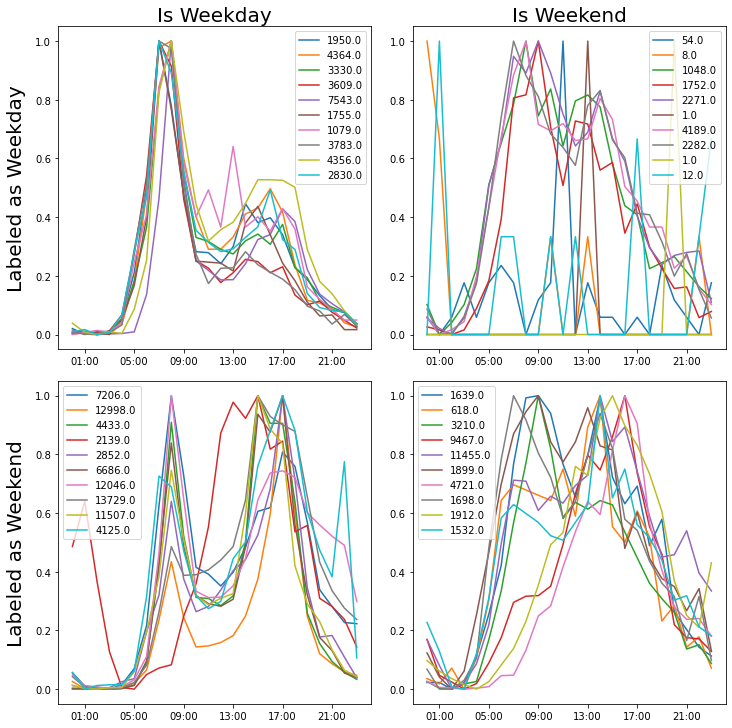

In [16]:
def extract_row(ind, df):
    return df.loc[ind][hour_columns].to_numpy()

#     A_B       : indices of kmeans_labelled_DSBH, where A is labelled as B 
#                 for (A, B) in [WEEKDAY, WEEKEND]
def two_by_two_weekendXweekday_plot(model_label_name, df, LINES_PER_PLOT, do_plot = True):
    
    print("pearson correlation:", {stats.pearsonr(df["is_weekday"], df[model_label_name])})
    
    if do_plot == False:
        return
    
    WEEKDAY_WEEKDAY = df[(df["is_weekday"] == 1) & (df["is_weekday"] == df[model_label_name])].index.to_numpy()
    WEEKDAY_WEEKEND = df[(df["is_weekday"] == 1) & (df["is_weekday"] != df[model_label_name])].index.to_numpy()

    WEEKEND_WEEKEND = df[(df["is_weekday"] == 0) & (df["is_weekday"] == df[model_label_name])].index.to_numpy()
    WEEKEND_WEEKDAY = df[(df["is_weekday"] == 0) & (df["is_weekday"] != df[model_label_name])].index.to_numpy()


    fig, axs = plt.subplots(2, 2, figsize = (10, 10))
    fig.tight_layout()

    rng = np.random.default_rng(11601)

    sampleDD = rng.choice(WEEKDAY_WEEKDAY, LINES_PER_PLOT)
    sampleDE = rng.choice(WEEKDAY_WEEKEND, LINES_PER_PLOT)
    sampleEE = rng.choice(WEEKEND_WEEKEND, LINES_PER_PLOT)
    sampleED = rng.choice(WEEKEND_WEEKDAY, LINES_PER_PLOT)

    for i in range(LINES_PER_PLOT):

        times = pd.DataFrame([pd.Timestamp(year = 2025, month = 1, day = 1, hour = i) for i in range(24)])

        axs[0, 0].plot(np.array(times), extract_row(sampleDD[i], df), label = df["tot_ridership"][sampleDD[i]])#, color="k")
        axs[1, 0].plot(np.array(times), extract_row(sampleDE[i], df), label = df["tot_ridership"][sampleDE[i]])#, color="r")
        axs[1, 1].plot(np.array(times), extract_row(sampleEE[i], df), label = df["tot_ridership"][sampleEE[i]])#, color="b")
        axs[0, 1].plot(np.array(times), extract_row(sampleED[i], df), label = df["tot_ridership"][sampleED[i]])#, color="g")

    add_headers(fig, col_headers = ["Is Weekday", "Is Weekend"], row_headers = ["Labeled as Weekday", "Labeled as Weekend"])    


    axs[0, 0].xaxis.set_major_locator(dates.HourLocator(interval=4))
    axs[0, 0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    axs[0, 1].xaxis.set_major_locator(dates.HourLocator(interval=4))
    axs[0, 1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    axs[1, 1].xaxis.set_major_locator(dates.HourLocator(interval=4))
    axs[1, 1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    axs[1, 0].xaxis.set_major_locator(dates.HourLocator(interval=4))
    axs[1, 0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 1].legend()
    axs[1, 0].legend()


#print(extract_row(0, kmeans_labelled_DSBH))

#fig, axs = plt.subplots(1, 2, figsize = (14, 7))

#correlation_true_kmeans = kmeans_labelled_DSBH['is_weekday'].corr(kmeans_labelled_DSBH['kmeans_label'])
#correlation_true_kmeans

two_by_two_weekendXweekday_plot("kmeans_label", kmeans_labelled_DSBH, LINES_PER_PLOT = 10)


The plots above show daily ridership by hour, depending on whether they were weekday/weekend and whether the kmeans model labelled them as such. (Of course, k-means does not know whether what it is labelling is a weekend or a weekday, because there is a positive correlation between it's labelling and the true weekday/weekend, I make one label mean "weekend" and the other to mean "weekday"). The line labels indicate the total daily ridership for that day and station. 

Plots sharing a column are the same kind of day (weekend or weekday), as given by the header. Plots sharing a row were labelled the same by the model.

Thus, plots on the diagonal have been properly identified, whereas plots on the off-diagonal were improperly labelled. Interestingly, weekdays were identified. It seems that the split identified by kmeans is whether there is a strong 7am/8am peak or not.

Interestingly, the model fails to identify weekend/weekday when there are a lot of riders (>10k) or very few (<100). Most likely, more popular and less popular stations have irregular ridership patterns. It may be worthwhile to remove strong outliers from the dataset.

A reasonable metric to check if the model is working properly is calculating the pearson correlation coefficient between the 'true label' (1 for weekday, 0 for weekend), and the k-means label. The correlation above is 0.5004, which shows a moderate correlation.

All in all, the kmeans clustering data needs to be modified a bit. Perhaps including the total ridership for that station that day (normalized) in the kmeans data can make an improvement.

In [17]:
kmeans_w_tot = KMeans(n_clusters = 2, random_state = 0)
kmeans_w_tot.fit(daily_station_ridership_by_hour[["tot_ridership_norm"] + hour_columns])

kmeans_labelled_DSBH_tot = pd.concat([daily_station_ridership_by_hour, pd.DataFrame(1 - kmeans_w_tot.labels_).rename(columns={0: "kmeans_wtot_label"})], axis = 1)
kmeans_labelled_DSBH_tot = kmeans_labelled_DSBH_tot[["transit_day", "station_complex", "is_weekday", "kmeans_wtot_label", "tot_ridership", "tot_ridership_norm"] + hour_columns]
kmeans_labelled_DSBH_tot.head(10)


,transit_day,station_complex,is_weekday,kmeans_wtot_label,tot_ridership,tot_ridership_norm,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,10,103 St-Corona Plaza (7),1,1,19925.0,0.136286,0.004132,0.000000,0.001271,0.015575,0.109663,0.410362,0.682454,1.000000,0.742212,0.408773,0.314050,0.220915,0.203433,0.249523,0.346790,0.297203,0.267959,0.241577,0.183408,0.153528,0.096631,0.079466,0.064209,0.041958
1,10,103 St (1),1,0,8880.0,0.060735,0.037797,0.007559,0.000000,0.000000,0.007559,0.042117,0.167387,0.619870,1.000000,0.632829,0.453564,0.511879,0.451404,0.479482,0.553996,0.667387,0.699784,0.785097,0.765659,0.474082,0.301296,0.258099,0.199784,0.136069
2,10,103 St (6),1,0,9334.0,0.063840,0.017586,0.001599,0.000799,0.000000,0.027178,0.074341,0.205436,0.550759,0.605915,0.353317,0.278177,0.300560,0.296563,0.353317,0.552358,1.000000,0.784972,0.735412,0.392486,0.294165,0.183853,0.109512,0.085532,0.065548
3,10,"103 St (C,B)",1,1,3072.0,0.021006,0.000000,0.000000,0.000000,0.000000,0.000000,0.080729,0.257812,0.716146,1.000000,0.565104,0.388021,0.375000,0.375000,0.398438,0.549479,0.567708,0.611979,0.640625,0.591146,0.341146,0.260417,0.161458,0.067708,0.052083
4,10,104 St (A),1,1,1249.0,0.008537,0.013393,0.008929,0.000000,0.044643,0.089286,0.410714,0.794643,1.000000,0.705357,0.263393,0.258929,0.165179,0.187500,0.200893,0.361607,0.267857,0.250000,0.138393,0.107143,0.093750,0.084821,0.071429,0.031250,0.026786
5,10,"104 St (J,Z)",1,1,2029.0,0.013872,0.014793,0.000000,0.017751,0.026627,0.139053,0.437870,0.582840,1.000000,0.736686,0.340237,0.242604,0.195266,0.257396,0.254438,0.402367,0.304734,0.325444,0.165680,0.156805,0.094675,0.097633,0.071006,0.047337,0.020710
6,10,110 St (6),1,1,7953.0,0.054394,0.010604,0.002121,0.000000,0.013786,0.030753,0.127253,0.317073,0.811241,1.000000,0.583245,0.363733,0.394486,0.346766,0.372216,0.667020,0.783669,0.676564,0.633086,0.355249,0.293743,0.252386,0.131495,0.090138,0.049841
7,10,111 St (7),1,1,8041.0,0.054996,0.009148,0.000000,0.002111,0.020408,0.109782,0.493315,0.652357,1.000000,0.777621,0.378607,0.270232,0.192822,0.171006,0.184377,0.229416,0.225897,0.208304,0.187896,0.132301,0.075299,0.064743,0.061928,0.052076,0.023927
8,10,111 St (A),1,1,1431.0,0.009782,0.000000,0.012579,0.009434,0.025157,0.047170,0.342767,0.710692,1.000000,0.575472,0.295597,0.160377,0.194969,0.138365,0.141509,0.172956,0.110063,0.141509,0.132075,0.081761,0.075472,0.037736,0.053459,0.028302,0.012579
9,10,111 St (J),1,1,1694.0,0.011581,0.000000,0.004292,0.012876,0.051502,0.150215,0.381974,0.579399,1.000000,0.708155,0.390558,0.278970,0.278970,0.304721,0.433476,0.626609,0.424893,0.356223,0.351931,0.270386,0.197425,0.120172,0.128755,0.094421,0.021459


pearson correlation: {(0.49979957524976637, 0.0)}


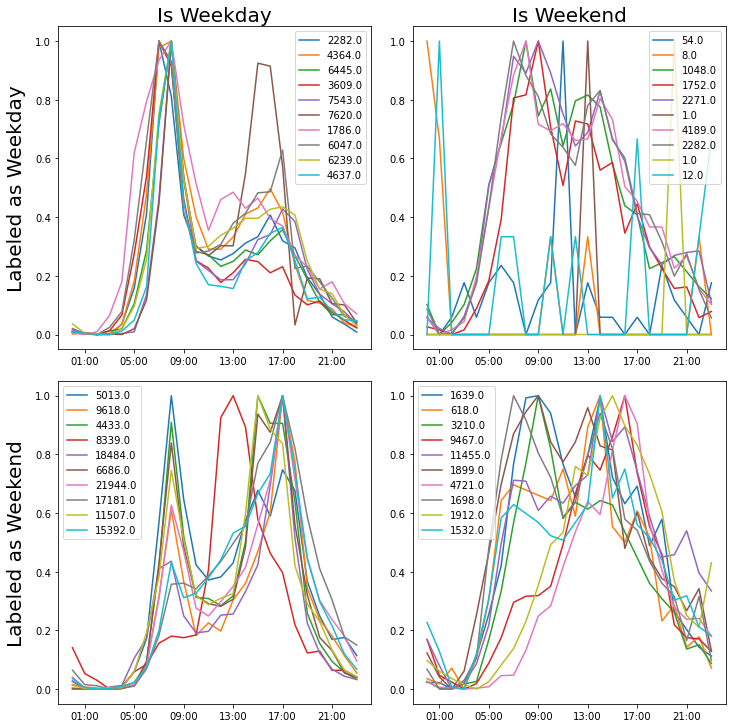

In [18]:
two_by_two_weekendXweekday_plot("kmeans_wtot_label", kmeans_labelled_DSBH_tot, LINES_PER_PLOT = 10, do_plot = True)

Just looking at the plots, there doesn't seem to have been a significant difference. The Pearson Correlation Coefficient actually shows a decrease in the model performance.

Before switching to new models, it might be interesting to try running kmeans on the *fourier transform* of the daily ridership by hour plots. The fourier transform will pick up the distinct peaks at 8 hour intervals, the commuter signal. This is desirable since it seems that kmeans on just the hourly data seems to discriminate based on whether the 7am/8am peak is strong or weak, whereas a work-day should include two noticeable peaks at 7am/8am and 5pm/6pm, vs. a lack of peaks.

Text(0.5, 1.0, 'FFT of Curves on the Left')

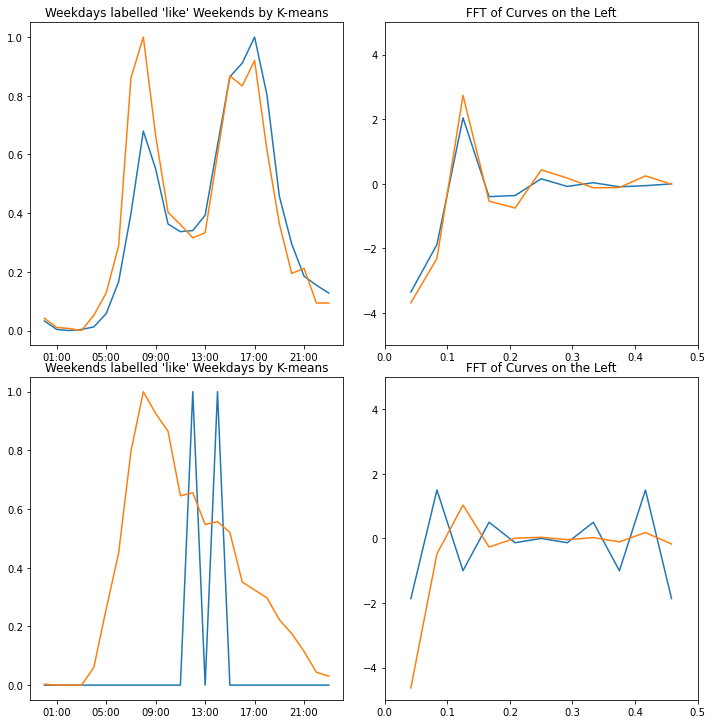

In [19]:
test_weekday = []
test_weekend = []

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.tight_layout()

WEEKDAY_WEEKDAY = kmeans_labelled_DSBH_tot[(kmeans_labelled_DSBH_tot["is_weekday"] == 1) & (kmeans_labelled_DSBH_tot["is_weekday"] == kmeans_labelled_DSBH_tot["kmeans_wtot_label"])].index.to_numpy()
WEEKDAY_WEEKEND = kmeans_labelled_DSBH_tot[(kmeans_labelled_DSBH_tot["is_weekday"] == 1) & (kmeans_labelled_DSBH_tot["is_weekday"] != kmeans_labelled_DSBH_tot["kmeans_wtot_label"])].index.to_numpy()

WEEKEND_WEEKEND = kmeans_labelled_DSBH_tot[(kmeans_labelled_DSBH_tot["is_weekday"] == 0) & (kmeans_labelled_DSBH_tot["is_weekday"] == kmeans_labelled_DSBH_tot["kmeans_wtot_label"])].index.to_numpy()
WEEKEND_WEEKDAY = kmeans_labelled_DSBH_tot[(kmeans_labelled_DSBH_tot["is_weekday"] == 0) & (kmeans_labelled_DSBH_tot["is_weekday"] != kmeans_labelled_DSBH_tot["kmeans_wtot_label"])].index.to_numpy()

test_weekday1 = extract_row(WEEKDAY_WEEKEND[100], kmeans_labelled_DSBH)
test_weekday2 = extract_row(WEEKDAY_WEEKEND[25], kmeans_labelled_DSBH)
test_weekend1 = extract_row(WEEKEND_WEEKDAY[12], kmeans_labelled_DSBH)
test_weekend2 = extract_row(WEEKEND_WEEKDAY[14], kmeans_labelled_DSBH)

frequencies = np.fft.fftfreq(24)

times = pd.DataFrame([pd.Timestamp(year = 2025, month = 1, day = 1, hour = i) for i in range(24)])

axs[0, 0].plot(np.array(times), test_weekday1)
axs[0, 0].plot(np.array(times), test_weekday2)
axs[1, 0].plot(np.array(times), test_weekend1)
axs[1, 0].plot(np.array(times), test_weekend2)

axs[0, 1].plot(frequencies[1:12], np.real(fft(test_weekday1)[1:12]))
axs[0, 1].plot(frequencies[1:12], np.real(fft(test_weekday2)[1:12]))

axs[1, 1].plot(frequencies[1:12], np.real(fft(test_weekend1)[1:12]))
axs[1, 1].plot(frequencies[1:12], np.real(fft(test_weekend2)[1:12]))



#axs[0].plot(np.array(times), test_row)#, label = df["tot_ridership"][sampleDD[i]])#, color="k"))

axs[0, 0].set_title("Weekdays labelled \'like\' Weekends by K-means")
axs[0, 0].xaxis.set_major_locator(dates.HourLocator(interval=4))
axs[0, 0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))


axs[0, 1].set_xlim(0, 0.5)
axs[0, 1].set_ylim(-5, 5)
axs[0, 1].set_title("FFT of Curves on the Left")

axs[1, 0].set_title("Weekends labelled \'like\' Weekdays by K-means")
axs[1, 0].xaxis.set_major_locator(dates.HourLocator(interval=4))
axs[1, 0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))


axs[1, 1].set_xlim(0, 0.5)
axs[1, 1].set_ylim(-5, 5)
axs[1, 1].set_title("FFT of Curves on the Left")



K-means seemed to discriminate based on the first peak. But hopefully, allowing kmeans to learn on the fourier-transformed data could assist it in recognizing commuter behaviour.

The first row of plots shows how the fourier-transform of weekdays show a strong coinciding peak around 0.125 (= 1/8hr), while the second row of plots shows a (relative) lack of this signal. This is desirable.


In [20]:
def row_to_fft_normalized(hours):
    ffts = np.real(fft(hours))[1:12]
    fft_min = np.min(ffts)
    fft_max = np.max(ffts)
    
    # if daily_ridership is zero all day, fft will also be zero
    if (fft_max - fft_min) == 0:
        return ffts
    
    ffts = (ffts - fft_min)/(fft_max - fft_min)
    return ffts

fft_columns = [f"fft_{i}" for i in range(0, 11)]

daily_station_ridership_by_hour_plus_fft = pd.DataFrame(daily_station_ridership_by_hour)

daily_station_ridership_by_hour_plus_fft[fft_columns] = daily_station_ridership_by_hour_plus_fft.apply(lambda x: row_to_fft_normalized(x[hour_columns]), axis=1, result_type='expand')


K-means on **just** the Fourier Transformed data (No hourly data).

In [21]:
kmeans_on_fft = KMeans(n_clusters = 2, random_state = 0)
kmeans_on_fft.fit(daily_station_ridership_by_hour_plus_fft[fft_columns])

kmeans_on_fft.labels_

kmeans_labelled_DSBH_fft = pd.concat([daily_station_ridership_by_hour_plus_fft, pd.DataFrame(1 - kmeans_on_fft.labels_).rename(columns = {0: "kmeans_fft_label"})], axis = 1)
kmeans_labelled_DSBH_fft = kmeans_labelled_DSBH_fft[["transit_day", "station_complex", "is_weekday", "kmeans_fft_label", "tot_ridership"] + hour_columns + fft_columns].dropna()


In [22]:
two_by_two_weekendXweekday_plot("kmeans_fft_label", kmeans_labelled_DSBH_fft, LINES_PER_PLOT = 10, do_plot = False)


pearson correlation: {(0.8297466616886665, 0.0)}


Significant improvement! Now to add back the hourly data and see how the model does.

In [23]:
kmeans_on_fft_plus_hourly = KMeans(n_clusters = 2, random_state = 0)
kmeans_on_fft_plus_hourly.fit(daily_station_ridership_by_hour_plus_fft[hour_columns + fft_columns])

kmeans_on_fft_plus_hourly.labels_

kmeans_labelled_DSBH_fft_hourly = pd.concat([daily_station_ridership_by_hour_plus_fft, pd.DataFrame(kmeans_on_fft_plus_hourly.labels_).rename(columns = {0: "kmeans_fft_hourly_label"})], axis = 1)
kmeans_labelled_DSBH_fft_hourly = kmeans_labelled_DSBH_fft_hourly[["transit_day", "station_complex", "is_weekday", "kmeans_fft_hourly_label", "tot_ridership"] + hour_columns + fft_columns].dropna()
two_by_two_weekendXweekday_plot("kmeans_fft_hourly_label", kmeans_labelled_DSBH_fft_hourly, LINES_PER_PLOT = 10, do_plot = False)


pearson correlation: {(-0.7669251150324573, 0.0)}


This seems to have reduced the correlation from just the fourier data. (Here, ignore the negative sign of the correlation coefficient, only considering its magnitude, the negative sign is because I have labelled as 1 what kmeans labelled as 0).

It seems like just a bit more correlation can be squeezed out by only selecting two fourier columns and two hour columns, as shown in the cell below. It may be worthwhile to use PCA to reduce the dataset down to a few columns, later down the line.

In [24]:
#JUST SOME HOUR AND FFT COLUMNS   vvvvv

kmeans_on_fft_plus_hourly = KMeans(n_clusters = 2, random_state = 0)
kmeans_on_fft_plus_hourly.fit(daily_station_ridership_by_hour_plus_fft[hour_columns[22:] + [fft_columns[1]] + [fft_columns[3]]])

kmeans_on_fft_plus_hourly.labels_

kmeans_labelled_DSBH_fft_hourly = pd.concat([daily_station_ridership_by_hour_plus_fft, pd.DataFrame(kmeans_on_fft_plus_hourly.labels_).rename(columns = {0: "kmeans_fft_hourly_label"})], axis = 1)
kmeans_labelled_DSBH_fft_hourly = kmeans_labelled_DSBH_fft_hourly[["transit_day", "station_complex", "is_weekday", "kmeans_fft_hourly_label", "tot_ridership"] + hour_columns + fft_columns].dropna()
kmeans_labelled_DSBH_fft_hourly.head()
two_by_two_weekendXweekday_plot("kmeans_fft_hourly_label", kmeans_labelled_DSBH_fft_hourly, LINES_PER_PLOT = 10, do_plot = False)

pearson correlation: {(-0.8439274823147673, 0.0)}


Now that I've performed some analysis to figure out how clustering can be used to identify weekends/weekdays, I will split the dataset into a weekend and weekday dataset, and use clustering within these two subsets to identify interesting patterns.

In [25]:
# NOT CONSIDERING station/days with less than ridership_cutoff # of riders
ridership_min_cutoff = 500
ridership_max_cutoff = 200000

weekday_tossed = daily_station_ridership_by_hour_plus_fft[(daily_station_ridership_by_hour_plus_fft["is_weekday"] == 1) & ((daily_station_ridership_by_hour_plus_fft["tot_ridership"] <= ridership_min_cutoff) | (daily_station_ridership_by_hour_plus_fft["tot_ridership"] >= ridership_max_cutoff))]
weekend_tossed = daily_station_ridership_by_hour_plus_fft[(daily_station_ridership_by_hour_plus_fft["is_weekday"] == 0) & ((daily_station_ridership_by_hour_plus_fft["tot_ridership"] <= ridership_min_cutoff) | (daily_station_ridership_by_hour_plus_fft["tot_ridership"] >= ridership_max_cutoff))]


weekday_station_ridership_by_hour_plus_fft = daily_station_ridership_by_hour_plus_fft[(daily_station_ridership_by_hour_plus_fft["is_weekday"] == 1)&(daily_station_ridership_by_hour_plus_fft["tot_ridership"] > ridership_min_cutoff) & (daily_station_ridership_by_hour_plus_fft["tot_ridership"] < ridership_max_cutoff)]
weekend_station_ridership_by_hour_plus_fft = daily_station_ridership_by_hour_plus_fft[(daily_station_ridership_by_hour_plus_fft["is_weekday"] == 0)&(daily_station_ridership_by_hour_plus_fft["tot_ridership"] > ridership_min_cutoff) & (daily_station_ridership_by_hour_plus_fft["tot_ridership"] < ridership_max_cutoff)]

weekday_tossed.drop("is_weekday", inplace=True, axis = 1)
weekday_tossed.reset_index(drop = True, inplace=True)

weekend_tossed.drop("is_weekday", inplace=True, axis = 1)
weekend_tossed.reset_index(drop = True, inplace=True)

weekday_station_ridership_by_hour_plus_fft.drop("is_weekday", inplace=True, axis = 1)
weekend_station_ridership_by_hour_plus_fft.drop("is_weekday", inplace=True, axis = 1)

weekday_station_ridership_by_hour_plus_fft.reset_index(drop = True, inplace=True)
weekend_station_ridership_by_hour_plus_fft.reset_index(drop = True, inplace=True)

weekday_station_ridership_by_hour_plus_fft[hour_columns] = normalize(weekday_station_ridership_by_hour_plus_fft[hour_columns], axis = 1)
weekend_station_ridership_by_hour_plus_fft[hour_columns] = normalize(weekend_station_ridership_by_hour_plus_fft[hour_columns], axis = 1)

weekday_tossed[hour_columns] = normalize(weekday_tossed[hour_columns], axis = 1)
weekend_tossed[hour_columns] = normalize(weekend_tossed[hour_columns], axis = 1)

pca_columns = ["PCA_1", "PCA_2", "PCA_3"]

weekend_pca = PCA(n_components = 3, random_state = 0)

weekend_station_ridership_by_hour_plus_fft[pca_columns] = weekend_pca.fit_transform(weekend_station_ridership_by_hour_plus_fft[hour_columns + fft_columns])

weekend_tossed[pca_columns] = weekend_pca.transform(weekend_tossed[hour_columns + fft_columns])


weekday_pca = PCA(n_components = 3, random_state = 0)

weekday_station_ridership_by_hour_plus_fft[pca_columns] = weekday_pca.fit_transform(weekday_station_ridership_by_hour_plus_fft[hour_columns + fft_columns])

weekday_tossed[pca_columns] = weekday_pca.transform(weekday_tossed[hour_columns + fft_columns])


## WEEKEND ANALYSIS

The pair plot below uses PCA to help visualize the hourly data. I've colored by borough to look for any patterns. The different boroughs do not overlap completely, which means that some boroughs may have categoriocally different ridership behaviors than others. For example, in the first PCA component, Manhattan and The Bronx are almost completely separated.

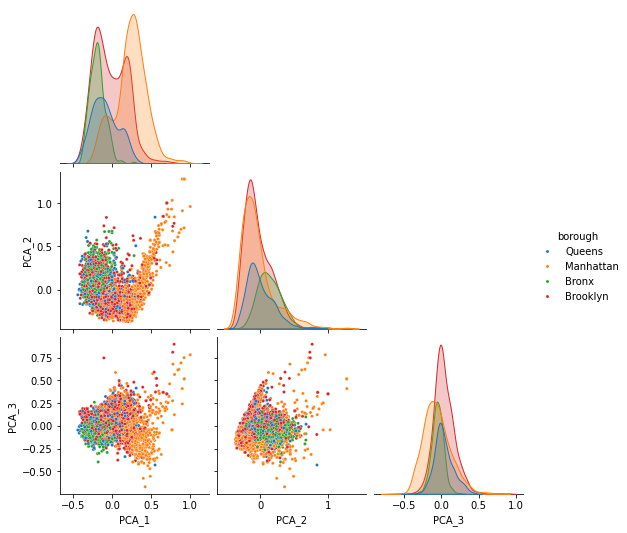

In [26]:
sns.pairplot(pd.merge(weekend_station_ridership_by_hour_plus_fft[pca_columns + ["station_complex"]], station_info_df, how = "inner", on ="station_complex")[pca_columns + ["borough"]], hue="borough", corner=True, plot_kws={'s': 10})


In [27]:
#sns.pairplot(pd.merge(weekday_station_ridership_by_hour_plus_fft[pca_columns + ["station_complex"]], station_info_df, how = "inner", on ="station_complex")[pca_columns + ["borough"]], hue="borough", corner=True, plot_kws={'s': 10})


In [28]:
weekend_ward_labels = AgglomerativeClustering(n_clusters = 3).fit_predict(weekend_station_ridership_by_hour_plus_fft[hour_columns + fft_columns])

weekend_station_hourly_ridership_ward_labelled = pd.concat([weekend_station_ridership_by_hour_plus_fft, pd.DataFrame(weekend_ward_labels).rename(columns={0:"ward_label"})], axis = 1)

weekend_tossed["ward_label"] = -1

weekend_complete = pd.concat([weekend_station_hourly_ridership_ward_labelled, weekend_tossed], axis=0)

# rearranging labels in a determined way for consistency

mean_0 = weekend_complete[weekend_complete["ward_label"] == 0]["PCA_1"].mean()
mean_1 = weekend_complete[weekend_complete["ward_label"] == 1]["PCA_1"].mean()
mean_2 = weekend_complete[weekend_complete["ward_label"] == 2]["PCA_1"].mean()

rearrange_to = np.argsort(np.argsort([mean_0, mean_1, mean_2])).tolist()
rearrange_to.append(-1)

weekend_complete["ward_label"] = weekend_complete["ward_label"].apply(lambda x: rearrange_to[x])




In [29]:
to_pair_plot_complete = weekend_complete[pca_columns + ["ward_label"]]


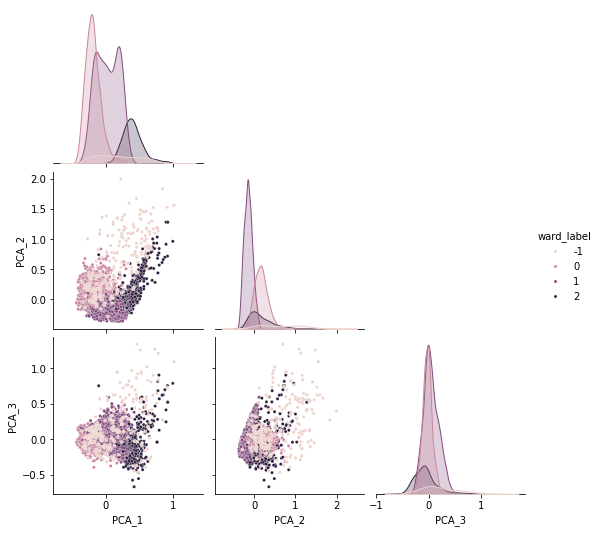

In [30]:
sns.pairplot(to_pair_plot_complete, hue = "ward_label", corner=True, plot_kws={'s':10})

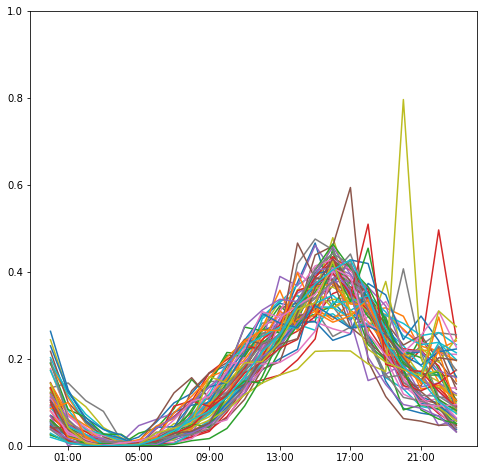

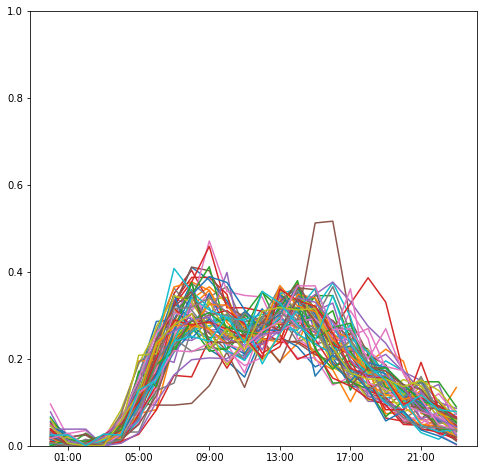

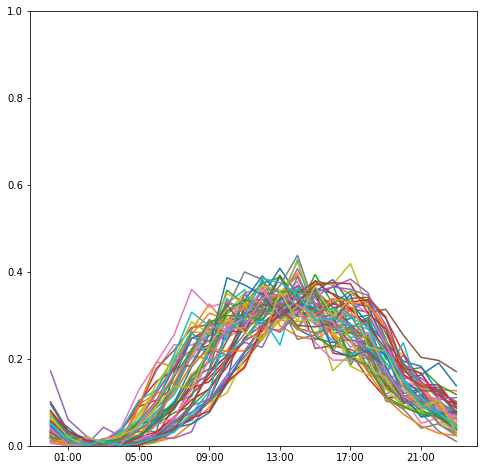

In [31]:
def plot_vals(df, label_name, label_val, LINES_TO_PLOT = 10):
    
    rng = np.random.default_rng(11601)
    
    inds_to_plot = rng.choice(df[df[label_name] == label_val].index.to_numpy(), size = LINES_TO_PLOT, replace = False)
    
    times = pd.DataFrame([pd.Timestamp(year = 2025, month = 1, day = 1, hour = i) for i in range(24)])
    
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    
    for ind in inds_to_plot:
        ax.plot(np.array(times), df.iloc[ind][hour_columns].to_numpy(), label = (f"day",df.iloc[ind]["transit_day"],"at ", df.iloc[ind]["station_complex"]))
    
    #ax.legend()
    
    ax.set_ylim(0, 1)
    
    ax.xaxis.set_major_locator(dates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    
    return

plot_vals(weekend_station_hourly_ridership_ward_labelled, label_name = "ward_label", label_val = 0, LINES_TO_PLOT = 60)
plot_vals(weekend_station_hourly_ridership_ward_labelled, label_name = "ward_label", label_val = 1, LINES_TO_PLOT = 60)
plot_vals(weekend_station_hourly_ridership_ward_labelled, label_name = "ward_label", label_val = 2, LINES_TO_PLOT = 60)
#plot_vals(weekend_station_hourly_ridership_ward_labelled, label_name = "ward_label", label_val = 3, LINES_TO_PLOT = 50)



The plots above show what the unsupervising learning labels correspond to. 

Label 0 shows workday-like ridership. On the weekends at these stations, a significant amount of riders are going to work.

Label 1 shows the expected weekend midday hump. This is the weekend station par excellence, riders are more than often going out. The midday hump has a wider breadth compared to label 0, riders are starting their weekend days earlier.

Label 2 shows the expected weekend midday hump, while also having a relatively higher ridership during the late night hours. This sort of station sees a lot of late night traffic, and may represent areas with more weekend late night destinations.


In [32]:
to_pair_plot = pd.merge(weekend_complete[pca_columns + ["station_complex", "ward_label"]], station_info_df, how = "inner", on ="station_complex")[pca_columns + ["borough", "ward_label"]]


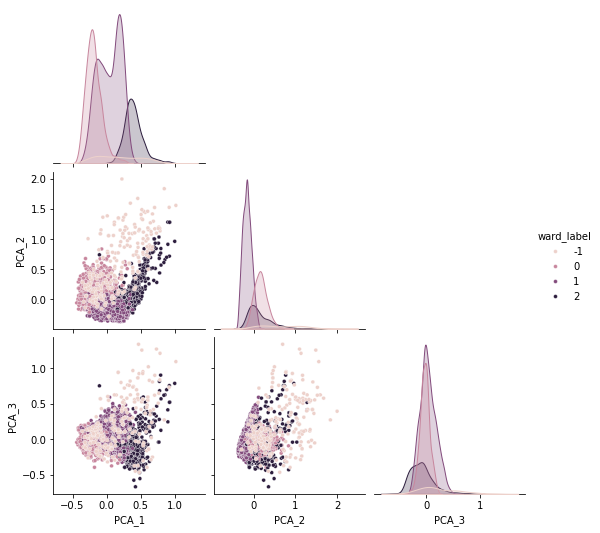

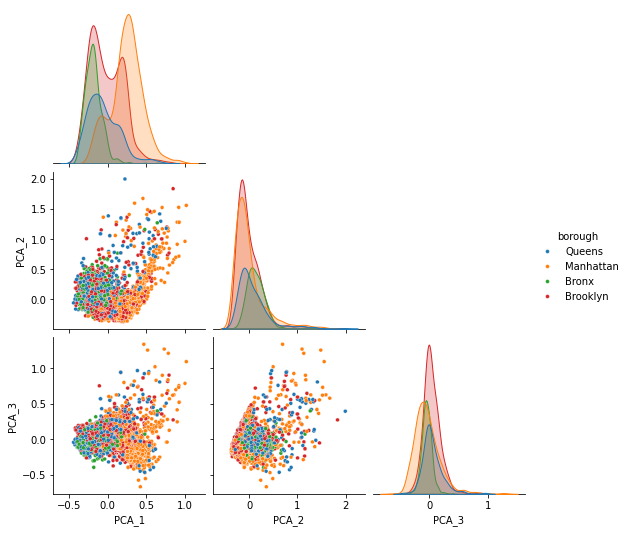

In [33]:
sns.pairplot(to_pair_plot[pca_columns + ["ward_label"]], hue = "ward_label", corner=True, plot_kws={'s': 15})
sns.pairplot(to_pair_plot[pca_columns + ["borough"]], hue = "borough", corner=True, plot_kws={'s': 15})



The first pair plot shows the labels plotted over PCA space, while the second pair plot reproduces the borough PCA visualization. As one may intuit, by looking at the first component of the PCA, Manhattan stations and weekend stations with strong late night ridership overlap. Furthermore, we find a large overlap between Bronx stations and stations with workday-like weekend ridership patterns.

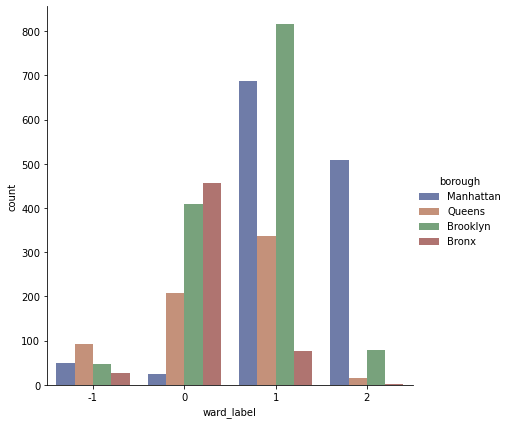

In [34]:
sns.catplot(data=to_pair_plot[["borough", "ward_label"]], kind="count", x="ward_label",hue="borough", errorbar="sd", palette="dark", alpha=.6, height=6)


In [35]:
weekend_complete_stripped = pd.merge(weekend_complete, station_info_df, how = "inner", on = "station_complex")[["transit_day", "station_complex", "latitude", "longitude", "ward_label", "tot_ridership"] + hour_columns]


#weekend_complete_stripped.head()

    BoroName                                           geometry
1     Queens  MULTIPOLYGON (((1029606.077 156073.814, 102957...
2   Brooklyn  MULTIPOLYGON (((1021176.479 151374.797, 102100...
3  Manhattan  MULTIPOLYGON (((981219.056 188655.316, 980940....
4      Bronx  MULTIPOLYGON (((1012821.806 229228.265, 101278...


TypeError: <lambda>() got an unexpected keyword argument 'axis'

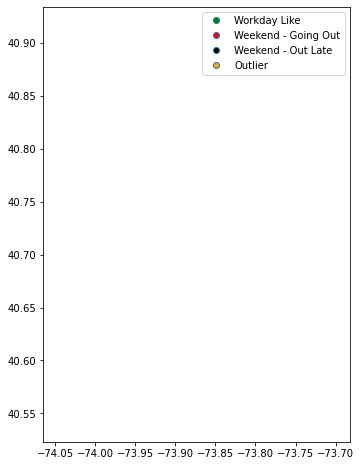

In [45]:
DAY_TO_MAP = 18

DAY_TO_MAP_STR = ""

if DAY_TO_MAP < 10:
    DAY_TO_MAP_STR += "0"

DAY_TO_MAP_STR += str(DAY_TO_MAP)

to_plot = weekend_complete_stripped[weekend_complete_stripped["transit_day"] == DAY_TO_MAP][["latitude", "longitude", "ward_label"]]
geometry = gpd.points_from_xy(x=to_plot["longitude"], y=to_plot["latitude"])

gdf = gpd.GeoDataFrame(to_plot, geometry=geometry)
gdf_boroughs = gpd.read_file("nybb.shp")[["BoroName", "geometry"]]

gdf_boroughs = gdf_boroughs[gdf_boroughs["BoroName"] != "Staten Island"] # sorry!
print(gdf_boroughs)
fig, ax = plt.subplots(figsize=(8, 8))

gdf_boroughs = gdf_boroughs.set_geometry("geometry")
boroughs_4326 = gdf_boroughs.to_crs("EPSG:4326")
boroughs_4326.plot(ax=ax, color = "white")

colors_list = ["green", "red", "black", "orange"]
label0 = plt.Line2D([], [], linestyle='none', marker='o', markerfacecolor=colors_list[0], alpha=1.00)
label1 = plt.Line2D([], [], linestyle='none', marker='o', markerfacecolor=colors_list[1], alpha=1.00)
label2 = plt.Line2D([], [], linestyle='none', marker='o', markerfacecolor=colors_list[2], alpha=1.00)
label3 = plt.Line2D([], [], linestyle='none', marker='o', markerfacecolor=colors_list[3], alpha=1.00)
ax.legend(handles=[label0, label1, label2, label3], labels=["Workday Like", "Weekend - Going Out", "Weekend - Out Late", "Outlier"])

gdf["color"] = gdf["ward_label"].apply(lambda x: colors_list[x])

plotted = gdf.plot(ax=ax, color = gdf["color"], markersize=4)
ax.set_facecolor('lightsteelblue')

circle_proxy = mpatches.Circle((0, 0), radius=0.5, color="red")


ax.set_title("Weekend Ridership Activity by Subway Station on 01-" + DAY_TO_MAP_STR + "-2025", fontsize=12)


The above plot labels the different stations by the designations I made above, for ridership on January 18, and places them on a map of New York City for better visual interpretation. Lower/Central Manhattan contains nearly all the *Weekend - Out Late* stations. As one moves further from Lower/Central Manhattan, the ridership behavior tends not to favor late nights as strongly, and further than that, riders are working more often on weekends. Stations in yellow had fewer than 500 riders.